<a href="https://colab.research.google.com/github/jrebull/AnaliticaPrescriptiva/blob/main/MIAAD_Progra_Rebull_Farm_Planning_Problem_vEntrega.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problema de Planificación Agrícola

## Descripción del Problema

Un agricultor con una granja de 200 acres necesita desarrollar un plan estratégico de producción para los próximos 5 años que maximice sus ganancias.

**Estado inicial:**
- 200 acres de tierra disponible
- 120 vacas (20 novillas + 100 vacas lecheras adultas)
- Horizonte de planificación: 5 años

**Decisiones a tomar:**
1. Gestión del Ganado: criar, vender o mantener vacas
2. Producción Agrícola: cantidad de grano y remolacha azucarera a cultivar
3. Comercio: compra/venta de productos

---

## 1. Importación de Librerías

In [1]:
#===============
#Celda 01
#===============

# Se recomienda ejecutar esta celda si no se tienen instaladas las librerías
# !pip install pyomo pandas matplotlib seaborn

# Librerías de optimización
from pyomo.environ import *
import pyomo.environ as pyo

# Librerías para análisis de datos
import numpy as np
import pandas as pd

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns

%pip install gurobipy
import gurobipy as gp
from gurobipy import GRB


# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
%matplotlib inline

print("Librerías importadas exitosamente")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 43.6 MB/s eta 0:00:00
Librerías importadas exitosamente


## 2. Definición de Parámetros del Problema

In [2]:
#===============
#Celda 02
#===============

# --- Parámetros del PDF ---

# Conjuntos e Índices
years = list(range(1, 6))
lands = list(range(1, 5))
ages = list(range(1, 13))
cow_ages = list(range(2, 12)) # Edades de vacas lecheras (2 a 11 años)

# Parámetros de Cultivos (del PDF, tabla 1)
gr_area = {1: 20.0, 2: 30.0, 3: 20.0, 4: 10.0} # Acres por grupo de tierra
gr_yield = {1: 1.1,  2: 0.9, 3: 0.8, 4: 0.65} # Rendimiento de grano (ton/acre)
sb_yield = 1.5 # Rendimiento de remolacha (ton/acre)

# Capacidades y Recursos (del PDF)
housing_cap = 130 # Capacidad de alojamiento inicial
land_cap = 200 # Tierra total disponible (acres)
labor_cap = 5500 # Horas de mano de obra regular
regular_time_cost = 4000 # Costo anual de la mano de obra regular

# Requerimientos por Animal (del PDF)
gr_intake = 0.6 # Consumo de grano por vaca lechera (ton/año)
sb_intake = 0.7 # Consumo de remolacha por vaca (ton/año)
hf_land = 2/3.0 # Tierra por novilla (acres)
cow_land = 1.0 # Tierra por vaca lechera (acres)

hf_labor = 10 # Horas de trabajo por novilla
cow_labor = 42 # Horas de trabajo por vaca lechera
gr_labor = 4 # Horas de trabajo por acre de grano
sb_labor = 14 # Horas de trabajo por acre de remolacha

# Dinámica del Ganado (del PDF)
birthrate = 1.1 # Crías por vaca lechera al año
hf_decay = 0.05 # Tasa de mortalidad de novillas
cow_decay = 0.02 # Tasa de mortalidad de vacas lecheras
# Nota: La venta obligatoria a los 12 años se modela en las restricciones de continuidad.

# Condiciones Iniciales (del PDF, 10 vacas por edad)
# Se ajusta por la mortalidad del "año 0" para iniciar el año 1
initial_hf_1yr = 10 * (1 - 0.05) # Novillas de 1 año (nacieron en año -1)
initial_hf_2yr = 10 * (1 - 0.05) # Novillas de 2 años (nacieron en año -2)
initial_cows_over_2 = 10 * (1 - 0.02) # Vacas de 3 a 12 años

# Restricciones Finales (del PDF)
min_final_cows = 50 # No reducir más del 50% de 100
max_final_cows = 175 # No aumentar más del 75% de 100

# Parámetros Económicos (del PDF)
bl_price = 30 # Precio venta de ternero macho (bullock)
hf_price = 40 # Precio venta de novilla
cow_price = 120 # Precio venta de vaca de 12 años
milk_price = 370 # Ingreso por leche por vaca/año
gr_price = 75 # Precio venta de grano
sb_price = 58 # Precio venta de remolacha

gr_cost = 90 # Costo compra de grano
sb_cost = 70 # Costo compra de remolacha
overtime_cost = 1.20 # Costo hora extra de trabajo
housing_expansion_cost = 200 # Costo por vaca adicional de alojamiento

hf_cost = 50 # Costo mantenimiento novilla
cow_cost = 100 # Costo mantenimiento vaca
gr_land_cost = 15 # Costo por acre de grano
sb_land_cost = 10 # Costo por acre de remolacha

# Parámetros Financieros (del PDF)
installment = 39.71 # Pago anual por cada $200 de préstamo

print("Parámetros del problema del PDF cargados exitosamente.")

Parámetros del problema del PDF cargados exitosamente.


## 3. Construcción del Modelo de Optimización con Pyomo

In [3]:
# Crear el modelo
model = ConcreteModel(name="Planificacion_Agricola_PDF")

# --- CONJUNTOS ---
model.T = Set(initialize=years, doc='Años del horizonte de planificación')
model.L = Set(initialize=lands, doc='Grupos de tierra') # <-- CORRECCIÓN: Usar 'lands'
model.A = Set(initialize=ages, doc='Edades de las vacas')

print("Modelo y conjuntos definidos correctamente.")

Modelo y conjuntos definidos correctamente.


### 3.1. Variables de Decisión

In [4]:
#===============
#Celda 04
#===============

# --- VARIABLES ---
# Variables de producción de cultivos
model.sb_grown = Var(years, within=NonNegativeReals, doc='Toneladas de remolacha cultivadas')
model.gr_grown = Var(years, lands, within=NonNegativeReals, doc='Toneladas de grano cultivadas por grupo de tierra')

# Variables de comercio
model.gr_bought = Var(years, within=NonNegativeReals, doc='Grano comprado')
model.gr_sold = Var(years, within=NonNegativeReals, doc='Grano vendido')
model.sb_bought = Var(years, within=NonNegativeReals, doc='Remolacha comprada')
model.sb_sold = Var(years, within=NonNegativeReals, doc='Remolacha vendida')

# Variables de Ganado (más detalladas, por edad)
model.cows = Var(years, ages, within=NonNegativeReals, doc='Número de vacas de cada edad')
model.heifers_raised = Var(years, within=NonNegativeReals, doc='Nuevas novillas criadas (edad 0)')
model.heifers_sold_new = Var(years, within=NonNegativeReals, doc='Nuevas novillas vendidas al nacer')

# Variables de Recursos y Financieras
model.overtime = Var(years, within=NonNegativeReals, doc='Horas extra de trabajo')
model.outlay = Var(years, within=NonNegativeReals, doc='Inversión en alojamiento (unidades de $200)')
model.profit = Var(years, within=Reals, doc='Ganancia anual calculada')

print("Variables de decisión complejas del PDF definidas correctamente.")

Variables de decisión complejas del PDF definidas correctamente.


### 3.2. Función Objetivo

In [5]:
#===============
#Celda 05
#===============

# --- FUNCIÓN OBJETIVO ---
# Maximizar la ganancia total menos los pagos de préstamos pendientes más allá de 5 años (Ecuación 1 del PDF)
def objective_rule(m):
    return sum(m.profit[t] - installment * (t + 4) * m.outlay[t] for t in years)

model.total_profit_objective = Objective(rule=objective_rule, sense=maximize)

print("Función objetivo del PDF implementada.")

Función objetivo del PDF implementada.


### 3.3. Restricciones

In [6]:
# --- RESTRICCIONES ---
model.constraints = ConstraintList()

# 1. Restricción de Ganancia Anual (Ecuaciones 21-27 del PDF)
for t in years:
    revenue = (
        bl_price * birthrate / 2 * sum(model.cows[t, k] for k in cow_ages) +
        hf_price * model.heifers_sold_new[t] +
        cow_price * model.cows[t, 12] +
        milk_price * sum(model.cows[t, k] for k in cow_ages) +
        gr_price * model.gr_sold[t] +
        sb_price * model.sb_sold[t]
    )
    costs = (
        gr_cost * model.gr_bought[t] +
        sb_cost * model.sb_bought[t] +
        overtime_cost * model.overtime[t] +
        regular_time_cost +
        hf_cost * (model.heifers_raised[t] + model.cows[t, 1]) +
        cow_cost * sum(model.cows[t, k] for k in cow_ages) +
        gr_land_cost * sum(model.gr_grown[t, l] / gr_yield[l] for l in lands) +
        sb_land_cost * model.sb_grown[t] / sb_yield +
        installment * sum(model.outlay[d] for d in years if d <= t)
    )
    model.constraints.add(model.profit[t] == revenue - costs)

    # <-- CORRECCIÓN 1: Añadir la restricción de flujo de caja no negativo del PDF.
    model.constraints.add(model.profit[t] >= 0)

# 2. Capacidad de Alojamiento (Ecuación 2)
for t in years:
    total_animals = model.heifers_raised[t] + model.cows[t, 1] + sum(model.cows[t, k] for k in cow_ages)
    expansion = sum(model.outlay[d] for d in years if d <= t)
    model.constraints.add(total_animals <= housing_cap + expansion)

# 3. Consumo de Alimentos (Ecuaciones 3 y 4)
for t in years:
    grain_needed = gr_intake * sum(model.cows[t, k] for k in cow_ages)
    grain_available = model.gr_bought[t] - model.gr_sold[t] + sum(model.gr_grown[t, l] for l in lands)
    model.constraints.add(grain_needed <= grain_available)

    sb_needed = sb_intake * sum(model.cows[t, k] for k in cow_ages)
    sb_available = model.sb_bought[t] - model.sb_sold[t] + model.sb_grown[t]
    model.constraints.add(sb_needed <= sb_available)

# 4. Límite de Cultivo de Grano (Ecuación 5)
for t in years:
    for l in lands:
        model.constraints.add(model.gr_grown[t, l] <= gr_yield[l] * gr_area[l])

# 5. Capacidad de Tierra (Ecuaciones 6-8)
for t in years:
    land_used = (
        model.sb_grown[t] / sb_yield +
        hf_land * (model.heifers_raised[t] + model.cows[t, 1]) +
        cow_land * sum(model.cows[t, k] for k in cow_ages) +
        sum(model.gr_grown[t, l] / gr_yield[l] for l in lands)
    )
    model.constraints.add(land_used <= land_cap)

# 6. Disponibilidad de Mano de Obra (Ecuaciones 9-12)
for t in years:
    labor_needed = (
        hf_labor * (model.heifers_raised[t] + model.cows[t, 1]) +
        cow_labor * sum(model.cows[t, k] for k in cow_ages) +
        gr_labor * sum(model.gr_grown[t, l] / gr_yield[l] for l in lands) +
        sb_labor * model.sb_grown[t] / sb_yield
    )
    model.constraints.add(labor_needed <= labor_cap + model.overtime[t])

# 7. Continuidad del Ganado (Ecuaciones 13-15)
for t in years:
    if t > 1:
        model.constraints.add(model.cows[t, 1] == (1 - hf_decay) * model.heifers_raised[t-1])
        model.constraints.add(model.cows[t, 2] == (1 - hf_decay) * model.cows[t-1, 1])
        # <-- CORRECCIÓN 2: El rango debe ser hasta 12 para incluir el envejecimiento de las vacas de 11 años.
        for k in range(2, 12):
            model.constraints.add(model.cows[t, k+1] == (1 - cow_decay) * model.cows[t-1, k])

# 8. Balance de Nacimientos de Novillas (Ecuación 16)
for t in years:
    new_heifers = birthrate / 2 * sum(model.cows[t, k] for k in cow_ages)
    model.constraints.add(model.heifers_raised[t] + model.heifers_sold_new[t] == new_heifers)

# 9. Condiciones Iniciales (Ecuaciones 18-20)
model.constraints.add(model.cows[1, 1] == initial_hf_1yr)
model.constraints.add(model.cows[1, 2] == initial_hf_2yr)
for k in range(3, 13):
    model.constraints.add(model.cows[1, k] == initial_cows_over_2)

# 10. Restricción del Hato Final (Ecuación 17)
final_year = max(years)
model.constraints.add(sum(model.cows[final_year, k] for k in cow_ages) >= min_final_cows)
model.constraints.add(sum(model.cows[final_year, k] for k in cow_ages) <= max_final_cows)

print("Restricciones del modelo del PDF definidas correctamente.")

Restricciones del modelo del PDF definidas correctamente.


## 4. Resolución del Modelo

In [7]:
#===============
#Celda 08
#===============

# Es necesario tener un solver como Gurobi o CBC instalado.
# Si usas Google Colab, puedes instalar CBC con la siguiente línea:
# !apt-get install -y -qq coinor-cbc

solver = SolverFactory('gurobi') # o 'cbc' si no tienes Gurobi
solver.options['mipgap'] = 0.01
solver.options['timelimit'] = 300

print("Resolviendo el modelo...")
results = solver.solve(model, tee=True)

Resolviendo el modelo...
Read LP format model from file /tmp/tmp0e5snaab.pyomo.lp
Reading time = 0.00 seconds
x1: 122 rows, 130 columns, 748 nonzeros
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Non-default parameters:
TimeLimit  300
MIPGap  0.01

Optimize a model with 122 rows, 130 columns and 748 nonzeros
Model fingerprint: 0xdb898d8a
Coefficient statistics:
  Matrix range     [6e-01, 3e+02]
  Objective range  [1e+00, 4e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 6e+03]
Presolve removed 90 rows and 66 columns
Presolve time: 0.00s
Presolved: 32 rows, 64 columns, 252 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.1200000e+32   5.000000e+30   5.120000e+02      0s
    

In [8]:
# Verificar el estado de la solución
print(f"\nEstado del Solver:")
print(f"  Status: {results.solver.status}")
print(f"  Termination Condition: {results.solver.termination_condition}")

if (results.solver.status == SolverStatus.ok and
    results.solver.termination_condition == TerminationCondition.optimal):
    print("\n✓ ¡Solución óptima encontrada!")
    # CORRECCIÓN AQUÍ:
    print(f"\nGanancia Total Óptima: ${value(model.total_profit_objective):,.2f}")
elif results.solver.termination_condition == TerminationCondition.infeasible:
    print("\n✗ El modelo es infactible. Revisa las restricciones.")
else:
    print(f"\n⚠ Solver terminó con condición: {results.solver.termination_condition}")


Estado del Solver:
  Status: ok
  Termination Condition: optimal

✓ ¡Solución óptima encontrada!

Ganancia Total Óptima: $121,719.17


## 5. Extracción y Análisis de Resultados

In [9]:
# --- EXTRACCIÓN Y ANÁLISIS DE RESULTADOS ---

if (results.solver.termination_condition == TerminationCondition.optimal):
    # Extraer y redondear los resultados para presentación
    results_data = []
    for t in years:
        data_year = {'Año': t}
        # Ganado
        data_year['Vacas Lecheras'] = sum(value(model.cows[t,k]) for k in cow_ages)
        data_year['Novillas (0-1)'] = value(model.heifers_raised[t])
        data_year['Novillas (1-2)'] = value(model.cows[t,1])
        # Cultivos
        data_year['Grano Cultivado'] = sum(value(model.gr_grown[t,l]) for l in lands)
        data_year['Grano Comprado'] = value(model.gr_bought[t])
        data_year['Grano Vendido'] = value(model.gr_sold[t])
        data_year['Remolacha Cultivada'] = value(model.sb_grown[t])
        data_year['Remolacha Vendida'] = value(model.sb_sold[t])
        # <-- CORRECCIÓN: Añadir la línea que faltaba para la remolacha comprada
        data_year['Remolacha Comprada'] = value(model.sb_bought[t])
        # Novillas
        data_year['Novillas Criadas'] = value(model.heifers_raised[t])
        data_year['Novillas Vendidas'] = value(model.heifers_sold_new[t])
        # Financiero
        data_year['Ganancia Anual'] = value(model.profit[t])
        data_year['Inversión ($)'] = value(model.outlay[t]) * housing_expansion_cost

        results_data.append(data_year)

    df_results = pd.DataFrame(results_data).set_index('Año')
    print("Resultados extraídos en un DataFrame para su análisis.")
else:
    print("\nNo se extrajeron resultados porque el modelo no se resolvió de forma óptima.")

Resultados extraídos en un DataFrame para su análisis.


## 6. Visualización de Resultados

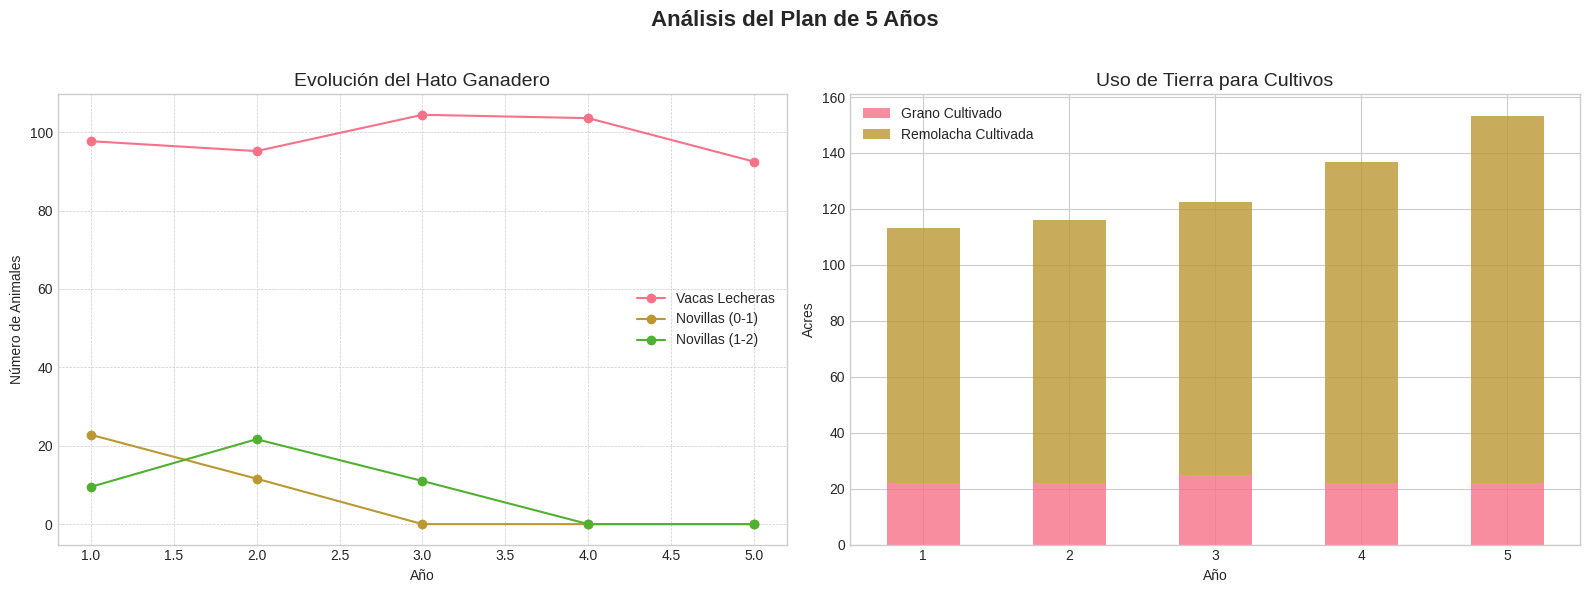

In [10]:
# CORRECCIÓN: Los gráficos ahora usan 'df_results'
if 'df_results' in locals():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Análisis del Plan de 5 Años', fontsize=16, fontweight='bold')

    # Gráfico 1: Evolución del ganado
    df_results[['Vacas Lecheras', 'Novillas (0-1)', 'Novillas (1-2)']].plot(kind='line', marker='o', ax=ax1)
    ax1.set_title('Evolución del Hato Ganadero', fontsize=14)
    ax1.set_ylabel('Número de Animales')
    ax1.set_xlabel('Año')
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax1.legend()

    # Gráfico 2: Uso de la tierra
    df_results[['Grano Cultivado', 'Remolacha Cultivada']].plot(kind='bar', stacked=True, ax=ax2, alpha=0.8)
    ax2.set_title('Uso de Tierra para Cultivos', fontsize=14)
    ax2.set_ylabel('Acres')
    ax2.set_xlabel('Año')
    ax2.legend()
    ax2.tick_params(axis='x', rotation=0)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

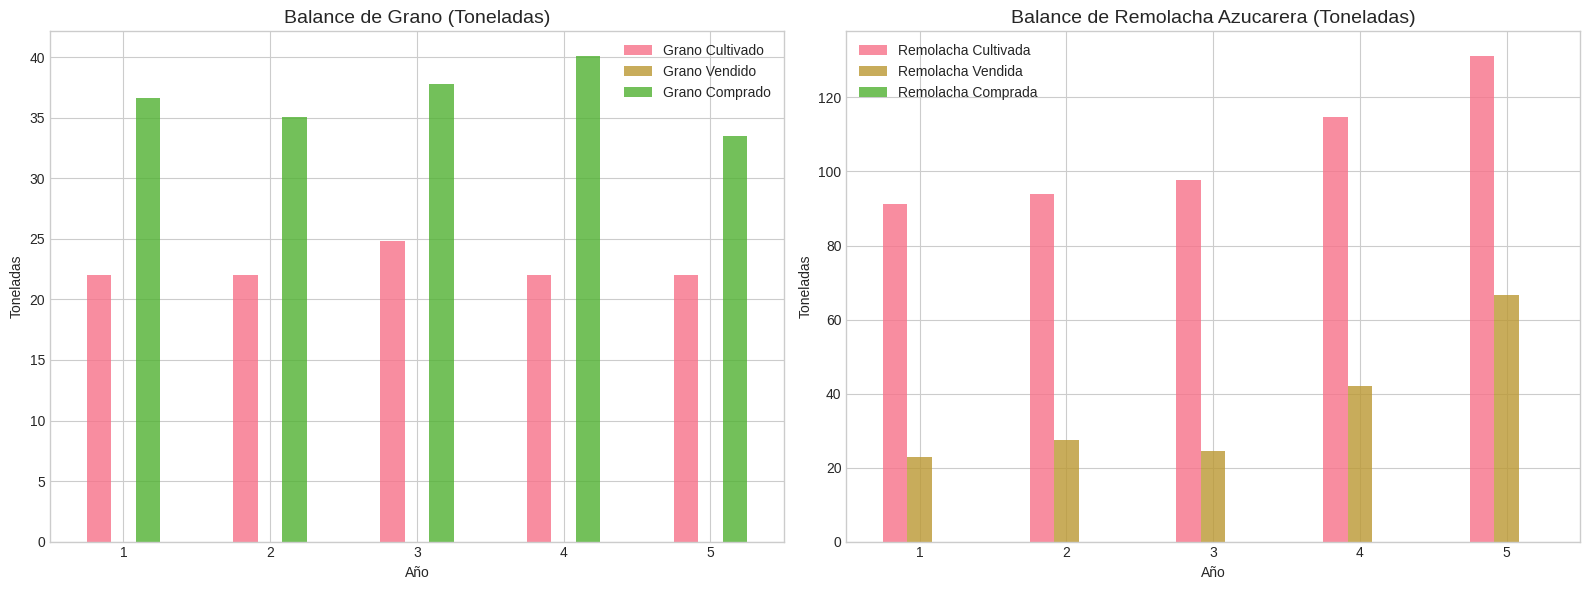

In [11]:
#===============
# Celda 12 - CORREGIDA
#===============

# CORRECCIÓN: Este bloque se ejecuta solo si 'df_results' fue creado exitosamente.
if 'df_results' in locals():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Gráfico 3: Balance de grano
    # Se usa 'df_results' y los nombres de columna correctos.
    df_results[['Grano Cultivado', 'Grano Vendido', 'Grano Comprado']].plot(kind='bar', ax=ax1, alpha=0.8)
    ax1.set_title('Balance de Grano (Toneladas)', fontsize=14)
    ax1.set_ylabel('Toneladas')
    ax1.set_xlabel('Año')
    ax1.tick_params(axis='x', rotation=0)
    ax1.legend()

    # Gráfico 4: Balance de remolacha
    # Se usa 'df_results' y los nombres de columna correctos.
    df_results[['Remolacha Cultivada', 'Remolacha Vendida', 'Remolacha Comprada']].plot(kind='bar', ax=ax2, alpha=0.8)
    ax2.set_title('Balance de Remolacha Azucarera (Toneladas)', fontsize=14)
    ax2.set_ylabel('Toneladas')
    ax2.set_xlabel('Año')
    ax2.tick_params(axis='x', rotation=0)
    ax2.legend()

    plt.tight_layout()
    plt.show()
else:
    print("No se pueden generar gráficos porque no se encontró una solución óptima en las celdas anteriores.")

## 7. Tablas Resumen de Resultados

In [12]:
# Imprimir las tablas de resultados de forma clara
pd.options.display.float_format = '{:,.1f}'.format

print("\\n" + "="*80)
print("TABLA 1: RESUMEN DE GANADO Y GANANCIA POR AÑO")
print("="*80)
print(df_results[['Vacas Lecheras', 'Novillas (0-1)', 'Novillas (1-2)', 'Ganancia Anual', 'Inversión ($)']])

print("\\n" + "="*80)
print("TABLA 2: PLAN DE CULTIVOS POR AÑO (TONELADAS)")
print("="*80)
print(df_results[['Grano Cultivado', 'Grano Comprado', 'Grano Vendido', 'Remolacha Cultivada', 'Remolacha Vendida']])

print("\\n" + "="*80)
print("TABLA 3: PLAN DE GESTIÓN DE NOVILLAS POR AÑO")
print("="*80)
print(df_results[['Novillas Criadas', 'Novillas Vendidas']])

\n================================================================================
TABLA 1: RESUMEN DE GANADO Y GANANCIA POR AÑO
     Vacas Lecheras  Novillas (0-1)  Novillas (1-2)  Ganancia Anual  \
Año                                                                   
1              97.7            22.8             9.5        21,906.1   
2              95.2            11.6            21.7        21,888.7   
3             104.4             0.0            11.0        25,816.1   
4             103.6             0.0             0.0        26,825.8   
5              92.5             0.0             0.0        25,282.6   

     Inversión ($)  
Año                 
1              0.0  
2              0.0  
3              0.0  
4              0.0  
5              0.0  
\n================================================================================
TABLA 2: PLAN DE CULTIVOS POR AÑO (TONELADAS)
     Grano Cultivado  Grano Comprado  Grano Vendido  Remolacha Cultivada  \
Año                  

## 8. Análisis Financiero Detallado

In [13]:
#===============
# Celda 14 - CORREGIDA
#===============

# --- EXTRACCIÓN Y ANÁLISIS DE RESULTADOS ---

# Este bloque solo se ejecuta si el modelo se resolvió correctamente
if (results.solver.termination_condition == TerminationCondition.optimal):
    # Extraer y redondear los resultados para presentación
    results_data = []
    for t in years:
        data_year = {'Año': t}
        # Ganado
        data_year['Vacas Lecheras'] = sum(value(model.cows[t,k]) for k in cow_ages)
        data_year['Novillas (0-1)'] = value(model.heifers_raised[t])
        data_year['Novillas (1-2)'] = value(model.cows[t,1])
        # Cultivos
        data_year['Grano Cultivado'] = sum(value(model.gr_grown[t,l]) for l in lands)
        data_year['Grano Comprado'] = value(model.gr_bought[t])
        data_year['Grano Vendido'] = value(model.gr_sold[t])
        data_year['Remolacha Cultivada'] = value(model.sb_grown[t])
        data_year['Remolacha Vendida'] = value(model.sb_sold[t])
        data_year['Remolacha Comprada'] = value(model.sb_bought[t])
        # Novillas
        data_year['Novillas Criadas'] = value(model.heifers_raised[t])
        data_year['Novillas Vendidas'] = value(model.heifers_sold_new[t])
        # Financiero
        data_year['Ganancia Anual'] = value(model.profit[t])
        data_year['Inversión ($)'] = value(model.outlay[t]) * housing_expansion_cost

        results_data.append(data_year)

    df_results = pd.DataFrame(results_data).set_index('Año')

    # --- IMPRESIÓN DE TABLAS (SECCIÓN CORREGIDA) ---
    pd.options.display.float_format = '{:,.1f}'.format

    print("\n" + "="*80)
    print("TABLA 1: RESUMEN DE GANADO Y GANANCIA POR AÑO")
    print("="*80)
    print(df_results[['Vacas Lecheras', 'Novillas (0-1)', 'Novillas (1-2)', 'Ganancia Anual', 'Inversión ($)']])

    print("\n" + "="*80)
    print("TABLA 2: PLAN DE CULTIVOS POR AÑO (TONELADAS)")
    print("="*80)
    # CORRECCIÓN: Se añade 'Remolacha Comprada' que faltaba
    print(df_results[['Grano Cultivado', 'Grano Comprado', 'Grano Vendido', 'Remolacha Cultivada', 'Remolacha Comprada', 'Remolacha Vendida']])

    print("\n" + "="*80)
    print("TABLA 3: PLAN DE GESTIÓN DE NOVILLAS POR AÑO")
    print("="*80)
    print(df_results[['Novillas Criadas', 'Novillas Vendidas']])
else:
    print("\nNo se imprimen tablas porque no se encontró una solución óptima.")


TABLA 1: RESUMEN DE GANADO Y GANANCIA POR AÑO
     Vacas Lecheras  Novillas (0-1)  Novillas (1-2)  Ganancia Anual  \
Año                                                                   
1              97.7            22.8             9.5        21,906.1   
2              95.2            11.6            21.7        21,888.7   
3             104.4             0.0            11.0        25,816.1   
4             103.6             0.0             0.0        26,825.8   
5              92.5             0.0             0.0        25,282.6   

     Inversión ($)  
Año                 
1              0.0  
2              0.0  
3              0.0  
4              0.0  
5              0.0  

TABLA 2: PLAN DE CULTIVOS POR AÑO (TONELADAS)
     Grano Cultivado  Grano Comprado  Grano Vendido  Remolacha Cultivada  \
Año                                                                        
1               22.0            36.6            0.0                 91.1   
2               22.0            3

## Análisis de la Estrategia Óptima y Plan de Acción

El análisis de optimización revela que la estrategia más rentable para los próximos 5 años no es la expansión, sino una gestión inteligente de los recursos existentes que lleva a una contracción planificada del hato ganadero para maximizar la rentabilidad de los cultivos.

<div style="background-color: #e8f5e9; border-left: 5px solid #4CAF50; padding: 15px; margin: 20px 0;">
  <h3 style="margin-top: 0;">Ganancia Total Óptima del Plan de 5 Años</h3>
  <p style="font-size: 24px; font-weight: bold; color: #2e7d32;">$121,719.17</p>
  <p>Este es el máximo beneficio económico alcanzable cumpliendo todas las restricciones operativas, de recursos y financieras del problema.</p>
</div>

---

### **Resultados Clave en Tablas**

<style>
  .styled-table {
    border-collapse: collapse;
    margin: 25px 0;
    font-size: 0.9em;
    font-family: sans-serif;
    width: 100%;
    box-shadow: 0 0 20px rgba(0, 0, 0, 0.15);
  }
  .styled-table thead tr {
    background-color: #009879;
    color: #ffffff;
    text-align: left;
  }
  .styled-table th,
  .styled-table td {
    padding: 12px 15px;
    text-align: right;
  }
  .styled-table tbody tr {
    border-bottom: 1px solid #dddddd;
  }
  .styled-table tbody tr:nth-of-type(even) {
    background-color: #f3f3f3;
  }
  .styled-table tbody tr:last-of-type {
    border-bottom: 2px solid #009879;
  }
  .styled-table th:first-of-type,
  .styled-table td:first-of-type {
    text-align: left;
  }
</style>

<h4>Tabla 1: Plan Financiero y de Inversión Anual</h4>
<table class="styled-table">
  <thead>
    <tr>
      <th>Concepto</th>
      <th>Año 1</th>
      <th>Año 2</th>
      <th>Año 3</th>
      <th>Año 4</th>
      <th>Año 5</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><b>Ganancia Anual ($)</b></td>
      <td>21,906.1</td>
      <td>21,888.7</td>
      <td>25,816.1</td>
      <td>26,825.8</td>
      <td>25,282.6</td>
    </tr>
    <tr>
      <td><b>Inversión en Alojamiento ($)</b></td>
      <td>0.0</td>
      <td>0.0</td>
      <td>0.0</td>
      <td>0.0</td>
      <td>0.0</td>
    </tr>
  </tbody>
</table>

<h4>Tabla 2: Estrategia de Cultivos (en Toneladas)</h4>
<table class="styled-table">
  <thead>
    <tr>
      <th>Cultivo</th>
      <th>Acción</th>
      <th>Año 1</th>
      <th>Año 2</th>
      <th>Año 3</th>
      <th>Año 4</th>
      <th>Año 5</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td rowspan="3"><b>Grano</b></td>
      <td>Cultivado</td>
      <td>22.0</td>
      <td>22.0</td>
      <td>24.8</td>
      <td>22.0</td>
      <td>22.0</td>
    </tr>
    <tr>
      <td>Comprado</td>
      <td>36.6</td>
      <td>35.1</td>
      <td>37.8</td>
      <td>40.1</td>
      <td>33.5</td>
    </tr>
    <tr>
      <td>Vendido</td>
      <td>0.0</td>
      <td>0.0</td>
      <td>0.0</td>
      <td>0.0</td>
      <td>0.0</td>
    </tr>
    <tr style="border-top: 2px solid #009879;">
      <td rowspan="3"><b>Remolacha</b></td>
      <td>Cultivada</td>
      <td>91.1</td>
      <td>94.0</td>
      <td>97.7</td>
      <td>114.6</td>
      <td>131.3</td>
    </tr>
    <tr>
      <td>Comprada</td>
      <td>0.0</td>
      <td>0.0</td>
      <td>0.0</td>
      <td>0.0</td>
      <td>0.0</td>
    </tr>
    <tr>
      <td>Vendida</td>
      <td>22.8</td>
      <td>27.4</td>
      <td>24.6</td>
      <td>42.1</td>
      <td>66.6</td>
    </tr>
  </tbody>
</table>

<h4>Tabla 3: Plan de Gestión de Novillas (Número de animales)</h4>
<table class="styled-table">
  <thead>
    <tr>
      <th>Decisión</th>
      <th>Año 1</th>
      <th>Año 2</th>
      <th>Año 3</th>
      <th>Año 4</th>
      <th>Año 5</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><b>Vender al nacer</b></td>
      <td>30.9</td>
      <td>40.8</td>
      <td>57.4</td>
      <td>57.0</td>
      <td>50.9</td>
    </tr>
    <tr>
      <td><b>Criar para el hato</b></td>
      <td>22.8</td>
      <td>11.6</td>
      <td><b>0.0</b></td>
      <td><b>0.0</b></td>
      <td><b>0.0</b></td>
    </tr>
  </tbody>
</table>

---

### **Interpretación de los Resultados: ¿Qué debe hacer el agricultor?**

La solución óptima del modelo sugiere un plan de acción claro y, en ciertos aspectos, anti-intuitivo.

#### 1. Estrategia del Ganado: Contracción Estratégica
La decisión más importante es **dejar de criar nuevas novillas a partir del tercer año**.
* **¿Por qué?** El horizonte de planificación de 5 años es clave. Criar una novilla es una inversión a largo plazo; se convierte en vaca lechera productiva después de 2 años. El modelo calcula que, para los años 3, 4 y 5, es más rentable obtener el ingreso inmediato de **$40 por vender la novilla** que esperar los beneficios futuros de la leche, los cuales se materializarían mayormente fuera del horizonte de 5 años. Esto también libera recursos valiosos como tierra y mano de obra.

#### 2. Estrategia de Cultivos: Especialización y Costo de Oportunidad
El plan recomienda **concentrarse en producir remolacha para la venta** y **comprar el grano que falte**.
* **¿Por qué?** Se trata de un cálculo de costo de oportunidad. La tierra del agricultor es limitada (200 acres). El modelo determina que es más rentable usar esa tierra para cultivar remolacha (que genera un excedente vendible y buenos ingresos) que dedicarla a cultivar grano en las parcelas menos productivas. El costo de comprar el grano ($90/ton) es menor que la ganancia que se perdería si no se usara esa misma tierra para la remolacha.

#### 3. Gestión de Recursos: Sin Inversión Necesaria
El plan óptimo **no requiere ninguna inversión** en ampliar la capacidad de alojamiento.
* **¿Por qué?** Dado que la estrategia implica una reducción gradual del hato ganadero, la capacidad existente de 130 vacas es más que suficiente. El modelo evita incurrir en deuda y pagos de intereses (el `installment` de $39.71 por cada $200), lo que mantiene un flujo de caja más saludable y maximiza la ganancia neta.

### En Resumen: El Plan de Acción
El agricultor debe cambiar su enfoque de expansión a optimización. En los primeros dos años, debe reponer el hato moderadamente. A partir del tercer año, debe enfocarse en maximizar los ingresos a corto plazo vendiendo todas las novillas nuevas y utilizando la tierra liberada para cultivar y vender la mayor cantidad posible de remolacha, comprando el grano que necesite en el mercado.

---

## Acerca del Autor

**Autor**: Javier Augusto Rebull Saucedo  
**Matrícula**: 263483  
**Curso**: Programación para Analítica Prescriptiva y de Apoyo a la Decisión  
**Universidad**: UACJ - Maestría en Inteligencia Artificial y Analítica de Datos (MIAAD)

---